In [3]:
#Nothing nowadays exhibits obvious cointegration that one can exploit 
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
from datetime import datetime, timedelta

# Define stock pairs
candidates = [("PEP","KO"),("XOM", "CVX"), ("JPM", "BAC")]

start_date = "1985-01-01"
end_date = "1988-01-01"

# Store results
cointegration_results = {}

for (stock1, stock2) in candidates:
    print(f"\nChecking {stock1} vs {stock2}")
    df = yf.download([stock1, stock2], start=start_date, end=end_date)["Close"].dropna()
    score, p_value, _ = coint(df[stock1], df[stock2])
    cointegration_results[(stock1, stock2)] = [p_value]
# Convert results to a DataFrame for easy viewing
cointegration_df = pd.DataFrame(cointegration_results,index=["p-value"]).T
cointegration_df


Checking PEP vs KO


[*********************100%***********************]  2 of 2 completed



Checking XOM vs CVX


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Checking JPM vs BAC


,,p-value
PEP,KO,0.070556
XOM,CVX,0.949631
JPM,BAC,0.429374


In [ ]:
# We select TGT and WMT as they seem to be cointegrated recently. We will use mean reverint approach based on Z-scores.

[*********************100%***********************]  2 of 2 completed


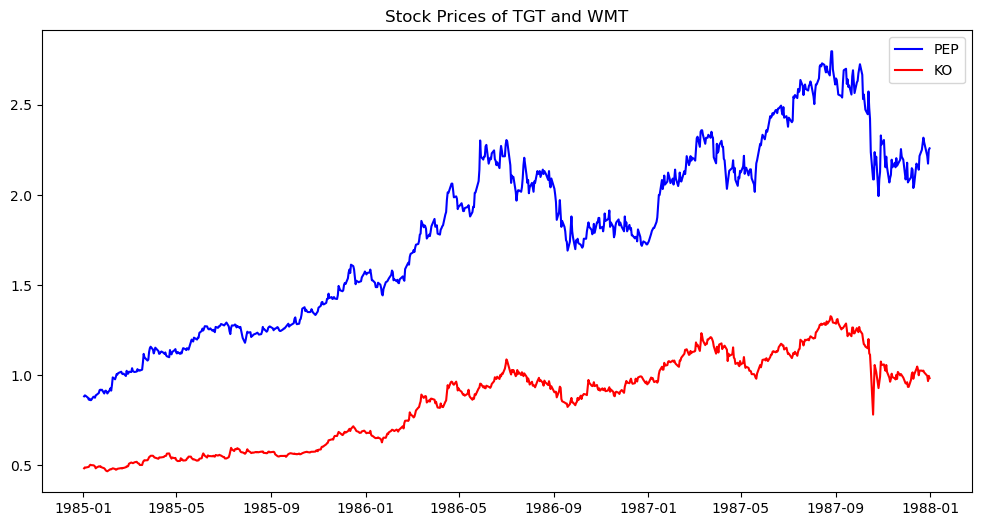

In [105]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define stock pair
stock1, stock2 = "PEP","KO"

# Fetch last 2 years of data
start_date = "1985-01-01"
end_date = "1988-01-01"

data = yf.download([stock1, stock2], start=start_date, end=end_date)['Close'].dropna()

# Plot price data
plt.figure(figsize=(12,6))
plt.plot(data.index, data[stock1], label=stock1, color="blue")
plt.plot(data.index, data[stock2], label=stock2, color="red")
plt.legend()
plt.title("Stock Prices of TGT and WMT")
plt.show()


[*********************100%***********************]  2 of 2 completed
C:\Users\piotr\AppData\Local\Temp\ipykernel_5516\4218495177.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio_ols = model_ols.params[1]  # OLS hedge ratio


ADF Test p-value: 0.0263
✅ The spread is stationary (suitable for pairs trading).


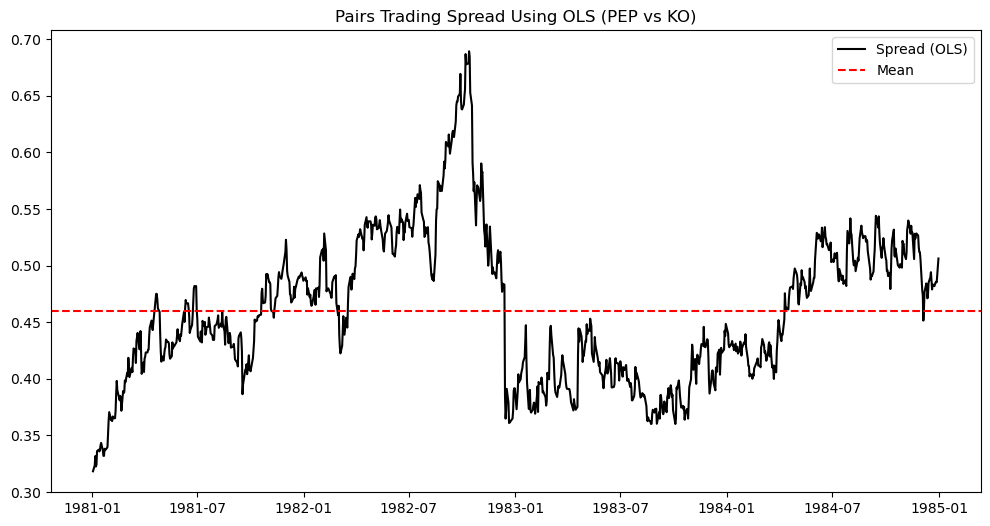

In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller

# Step 1: Download Data for PEP and KO (1980-1988)
start_date = "1981-01-01"
end_date = "1985-01-01"

tickers = ["PEP", "KO"]
data = yf.download(tickers, start=start_date, end=end_date)["Close"].dropna()

X = sm.add_constant(data["KO"])  # KO as independent variable
model_ols = sm.OLS(data["PEP"], X).fit()
hedge_ratio_ols = model_ols.params[1]  # OLS hedge ratio

# Step 3: Compute the Spread Using TLS Hedge Ratio
data["Spread_OLS"] = data["PEP"] - hedge_ratio_ols * data["KO"]

# Step 4: Check for Stationarity of the Spread (ADF Test)
adf_test = adfuller(data["Spread_OLS"].dropna())
print(f"ADF Test p-value: {adf_test[1]:.4f}")

if adf_test[1] < 0.05:
    print("✅ The spread is stationary (suitable for pairs trading).")
else:
    print("❌ The spread is NOT stationary (pairs trading may not work well).")

# Step 5: Plot the Spread Using TLS
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Spread_OLS"], label="Spread (OLS)", color="black")
plt.axhline(data["Spread_OLS"].mean(), color="red", linestyle="--", label="Mean")
plt.title("Pairs Trading Spread Using OLS (PEP vs KO)")
plt.legend()
plt.show()


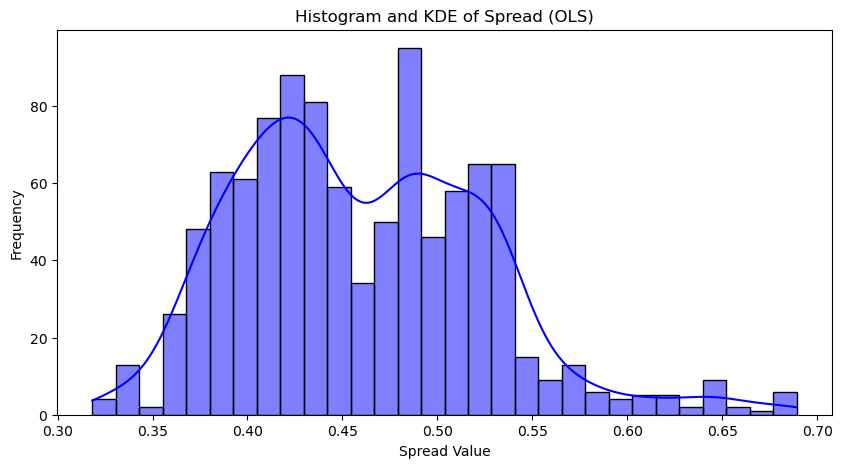

Shapiro-Wilk p-value: 0.0000
Jarque-Bera p-value: 0.0000
❌ The spread does NOT appear normally distributed (consider alternative thresholds).


In [28]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Check for Normality of the Spread Distribution
spread_values = data["Spread_OLS"].dropna()

# Shapiro-Wilk Test (tests if data is normally distributed)
shapiro_test = stats.shapiro(spread_values)
shapiro_p_value = shapiro_test.pvalue

# Jarque-Bera Test (another normality test)
jb_test = stats.jarque_bera(spread_values)
jb_p_value = jb_test[1]

# Plot histogram and KDE for visual confirmation
plt.figure(figsize=(10,5))
sns.histplot(spread_values, kde=True, bins=30, color="blue")
plt.title("Histogram and KDE of Spread (OLS)")
plt.xlabel("Spread Value")
plt.ylabel("Frequency")
plt.show()

# Display normality test results
print(f"Shapiro-Wilk p-value: {shapiro_p_value:.4f}")
print(f"Jarque-Bera p-value: {jb_p_value:.4f}")

if shapiro_p_value > 0.05 and jb_p_value > 0.05:
    print("✅ The spread appears normally distributed (Z-scores should work).")
else:
    print("❌ The spread does NOT appear normally distributed (consider alternative thresholds).")


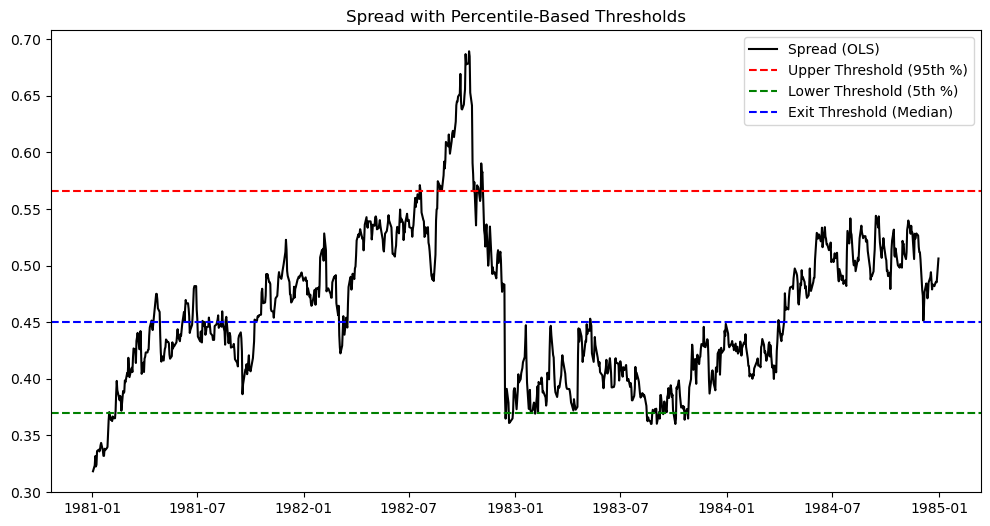

In [71]:
# Compute percentiles for thresholds
lower_threshold = np.percentile(data["Spread_OLS"], 5)  # 5th percentile
upper_threshold = np.percentile(data["Spread_OLS"], 95)  # 95th percentile
exit_threshold = np.percentile(data["Spread_OLS"], 50)  # Median as exit

# Plot the spread with percentile-based thresholds
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Spread_OLS"], label="Spread (OLS)", color="black")
plt.axhline(y=upper_threshold, color="red", linestyle="--", label="Upper Threshold (95th %)")
plt.axhline(y=lower_threshold, color="green", linestyle="--", label="Lower Threshold (5th %)")
plt.axhline(y=exit_threshold, color="blue", linestyle="--", label="Exit Threshold (Median)")
plt.title("Spread with Percentile-Based Thresholds")
plt.legend()
plt.show()


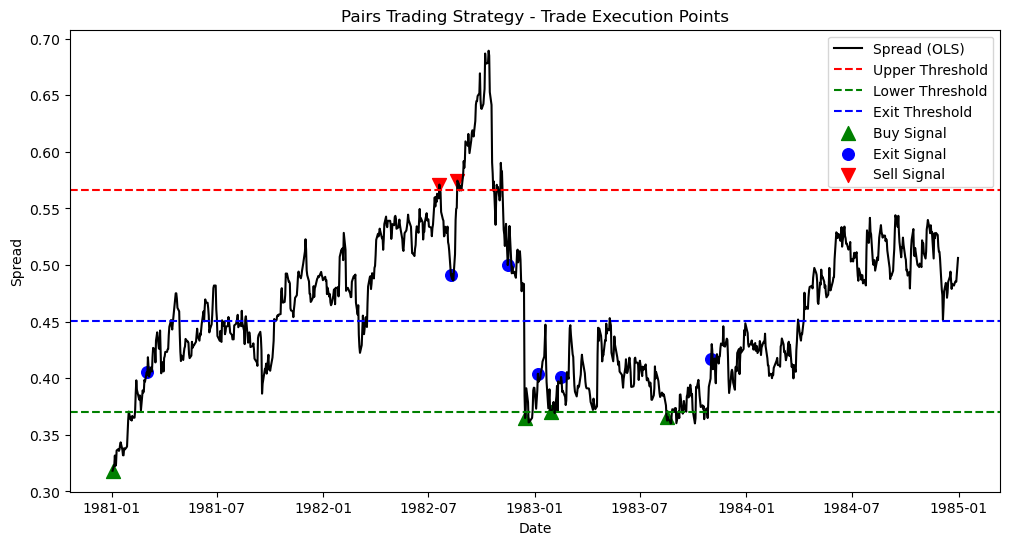

In [77]:
# Initialize trading signals
data["Long Signal"] = data["Spread_OLS"] < lower_threshold
data["Short Signal"] = data["Spread_OLS"] > upper_threshold
tolerance = 0  # Adjust this value based on your spread's characteristics

# Update Exit Signal condition
data["Exit Signal"] = abs(data["Spread_OLS"]-exit_threshold)<0.05

# Initialize variables
capital = 10000  # Starting capital
position_size = 1000  # Shares per trade
capital_over_time = []
in_position = False
trade_type = None  # Track if we are long or short
entry_prices = {}  # Store entry prices
trade_log = []  # List to track trades

for i in range(len(data)):
    if in_position:
        if data["Exit Signal"].iloc[i]:
            exit_price_PEP = data["PEP"].iloc[i]
            exit_price_KO = data["KO"].iloc[i]
            if trade_type == "long":
                profit_PEP = (exit_price_PEP - entry_prices["PEP"]) * position_size
                profit_KO = (entry_prices["KO"] - exit_price_KO) * position_size
            elif trade_type == "short":
                profit_PEP = (entry_prices["PEP"] - exit_price_PEP) * position_size
                profit_KO = (exit_price_KO - entry_prices["KO"]) * position_size
            capital += profit_PEP + profit_KO
            trade_log.append({
                "Date": data.index[i],
                "Type": "EXIT",
                "Exit Price PEP": exit_price_PEP,
                "Exit Price KO": exit_price_KO,
                "Profit PEP": profit_PEP,
                "Profit KO": profit_KO,
                "Total Profit": profit_PEP + profit_KO
            })
            in_position = False
            trade_type = None
            entry_prices = {}
    else:
        if data["Long Entry"].iloc[i]:
            entry_prices["PEP"] = data["PEP"].iloc[i]
            entry_prices["KO"] = data["KO"].iloc[i]
            trade_type = "long"
            in_position = True
            trade_log.append({
                "Date": data.index[i],
                "Type": "BUY (Long PEP, Short KO)",
                "Entry Price PEP": entry_prices["PEP"],
                "Entry Price KO": entry_prices["KO"]
            })
        elif data["Short Entry"].iloc[i]:
            entry_prices["PEP"] = data["PEP"].iloc[i]
            entry_prices["KO"] = data["KO"].iloc[i]
            trade_type = "short"
            in_position = True
            trade_log.append({
                "Date": data.index[i],
                "Type": "SELL (Short PEP, Long KO)",
                "Entry Price PEP": entry_prices["PEP"],
                "Entry Price KO": entry_prices["KO"]
            })
    capital_over_time.append(capital)

# Convert Trade Log into DataFrame
trade_log_df = pd.DataFrame(trade_log)

# Plot the Spread with Trade Markers
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Spread_OLS"], label="Spread (OLS)", color="black")
plt.axhline(y=upper_threshold, color="red", linestyle="--", label="Upper Threshold")
plt.axhline(y=lower_threshold, color="green", linestyle="--", label="Lower Threshold")
plt.axhline(y=exit_threshold, color="blue", linestyle="--", label="Exit Threshold")

# Plot Trade Markers
for _, trade in trade_log_df.iterrows():
    if "BUY" in trade["Type"]:
        plt.scatter(trade["Date"], data.loc[trade["Date"], "Spread_OLS"], marker="^", color="green", s=100, label="Buy Signal")
    elif "SELL" in trade["Type"]:
        plt.scatter(trade["Date"], data.loc[trade["Date"], "Spread_OLS"], marker="v", color="red", s=100, label="Sell Signal")
    elif "EXIT" in trade["Type"]:
        plt.scatter(trade["Date"], data.loc[trade["Date"], "Spread_OLS"], marker="o", color="blue", s=70, label="Exit Signal")

# Remove Duplicate Labels in Legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Pairs Trading Strategy - Trade Execution Points")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.show()